In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

## Load/Transform Data

In [9]:
start_year = 1985
end_year = 2015

# elevation [meters]
elevation = xr.open_dataset("../data/elevation_0.5deg.nc")['elevation']

# tmp - monthly average daily mean temperature [deg Celsius] monthly
tmp_monthly = xr.open_mfdataset("../data/cru_ts4.07.*.tmp.dat.nc").sel(time=slice(str(start_year), str(end_year)))['tmp'].load()

# MAT: mean annual temperature [deg Celsius]
mat = tmp_monthly.mean(dim='time').rename('mat')

# pre - precipitation [mm/month] monthly
pre_monthly = xr.open_mfdataset("../data/cru_ts4.07.*.pre.dat.nc").sel(time=slice(str(start_year), str(end_year)))['pre'].load()

# MAP: mean annual precipitation [mm/year]
map = (pre_monthly.sum(dim='time') / (end_year - start_year)).rename('map')

# pet - potential evapotranspiration [mm/day] monthly
pet_monthly = xr.open_mfdataset("../data/cru_ts4.07.*.pet.dat.nc").sel(time=slice(str(start_year), str(end_year)))['pet'].load()
pet_monthly = pet_monthly * pet_monthly['time'].dt.days_in_month # multiply by days in month, mm/day -> mm/month

# PET: mean annual potential evapotranspiration [mm/year]
pet = (pet_monthly.sum(dim='time') / (end_year - start_year)).rename('pet') # mm/month -> mm/year

# frs - frost day frequency	[days] monthly
frs_monthly = xr.open_mfdataset("../data/cru_ts4.07.*.frs.dat.nc").sel(time=slice(str(start_year), str(end_year)))['frs'].load()
# convert timedelta to float64
one_day = np.timedelta64(1, 'D')
frs_monthly = (frs_monthly / one_day).astype('float64')

# FRS: mean annual frost day frequency [days/year]
frs = (frs_monthly.sum(dim='time') / (end_year - start_year)) # days/month -> days/year

# ratio MAP:PET
ratio_map_pet = map / pet

/Users/chill/.pyenv/versions/3.11.1/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/chill/.pyenv/versions/3.11.1/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


## Compute climate zones

In [11]:
climate_zones = xr.DataArray(np.zeros(elevation.shape), dims=('lat', 'lon'), coords={'lat': elevation.lat, 'lon': elevation.lon})

In [12]:
mask_0 = (mat > 18) & (frs <= 7)
mask_1 = elevation > 1000
mask_2 = map > 2000
mask_3 = (map <= 2000) & (map > 1000)
mask_4 = mat > 10
mask_5 = ratio_map_pet > 1
mask_6 = mat > 0
mask_7 = (tmp_monthly < 10).all(dim='time')
land_mask = mat.notnull()

In [13]:
# 1 - Tropical Montane
climate_zones = xr.where(
    mask_0 & mask_1,
    1, climate_zones
)

# 2 - Tropical Wet
climate_zones = xr.where(
    mask_0 & ~mask_1 & mask_2,
    2, climate_zones
    )

# 3 - Tropical Moist
climate_zones = xr.where(
    mask_0 & ~mask_1 & ~mask_2 & mask_3,
    3, climate_zones
    )

# 4 - Tropical Dry
climate_zones = xr.where(
    mask_0 & ~mask_1 & ~mask_2 & ~mask_3,
    4, climate_zones
    )

# 5 - Warm Temperate Moist
climate_zones = xr.where(
    ~mask_0 & mask_4 & mask_5,
    5, climate_zones
    )

# 6 - Warm Temperate Dry
climate_zones = xr.where(
    ~mask_0 & mask_4 & ~mask_5,
    6, climate_zones
    )

# 7 - Cool Temperate Moist
climate_zones = xr.where(
    ~mask_0 & ~mask_4 & mask_6 & mask_5,
    7, climate_zones
    )

# 8 - Cool Temperate Dry
climate_zones = xr.where(
    ~mask_0 & ~mask_4 & mask_6 & ~mask_5,
    8, climate_zones
    )

# 11 - Polar Moist
climate_zones = xr.where(
    ~mask_0 & ~mask_6 & ~mask_4 & mask_7 & mask_5,
    11, climate_zones
    )

# 12 - Polar Dry
climate_zones = xr.where(
    ~mask_0 & ~mask_6 & ~mask_4 & mask_7 & ~mask_5,
    12, climate_zones
    )

# 9 - Boreal Moist
climate_zones = xr.where(
    ~mask_0 & ~mask_6 & ~mask_4 & ~mask_7 & mask_5,
    9, climate_zones
    )

# 10 - Boreal Dry
climate_zones = xr.where(
    ~mask_0 & ~mask_6 & ~mask_4 & ~mask_7 & ~mask_5,
    10, climate_zones
    )

# 0 - no data
climate_zones = xr.where(land_mask, climate_zones, 0)

In [25]:
mapping = {
    0: 'no data',
    1: 'Tropical Montane',
    2: 'Tropical Wet',
    3: 'Tropical Moist',
    4: 'Tropical Dry',
    5: 'Warm Temperate Moist',
    6: 'Warm Temperate Dry',
    7: 'Cool Temperate Moist',
    8: 'Cool Temperate Dry',
    9: 'Boreal Moist',
    10: 'Boreal Dry',
    11: 'Polar Moist',
    12: 'Polar Dry',
}

labels = list(mapping.values())
levels = range(14)
ticks = [i  + 0.5 for i in range(13)]
cmap = plt.get_cmap('viridis', 13)

In [16]:
climate_zones = climate_zones.rename('ipcc_climate_zone')

In [17]:
string = """
0: no data
1: Tropical Montane
2: Tropical Wet
3: Tropical Moist
4: Tropical Dry
5: Warm Temperate Moist
6: Warm Temperate Dry
7: Cool Temperate Moist
8: Cool Temperate Dry
9: Boreal Moist
10: Boreal Dry
11: Polar Moist
12: Polar Dry
"""

In [18]:
climate_zones = climate_zones.assign_attrs({
    "description": "IPCC Climate Zones, defined on page 3.47 and 3.48 of https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/4_Volume4/19R_V4_Ch03_Land Representation.pdf, ammended with updates described at https://www.ipcc-nggip.iges.or.jp/public/2019rf/corrigenda1.html",
    "Labels for climate zones": string,
    })

In [15]:
climate_zones.to_netcdf('../data/ipcc_climate_zones.nc')

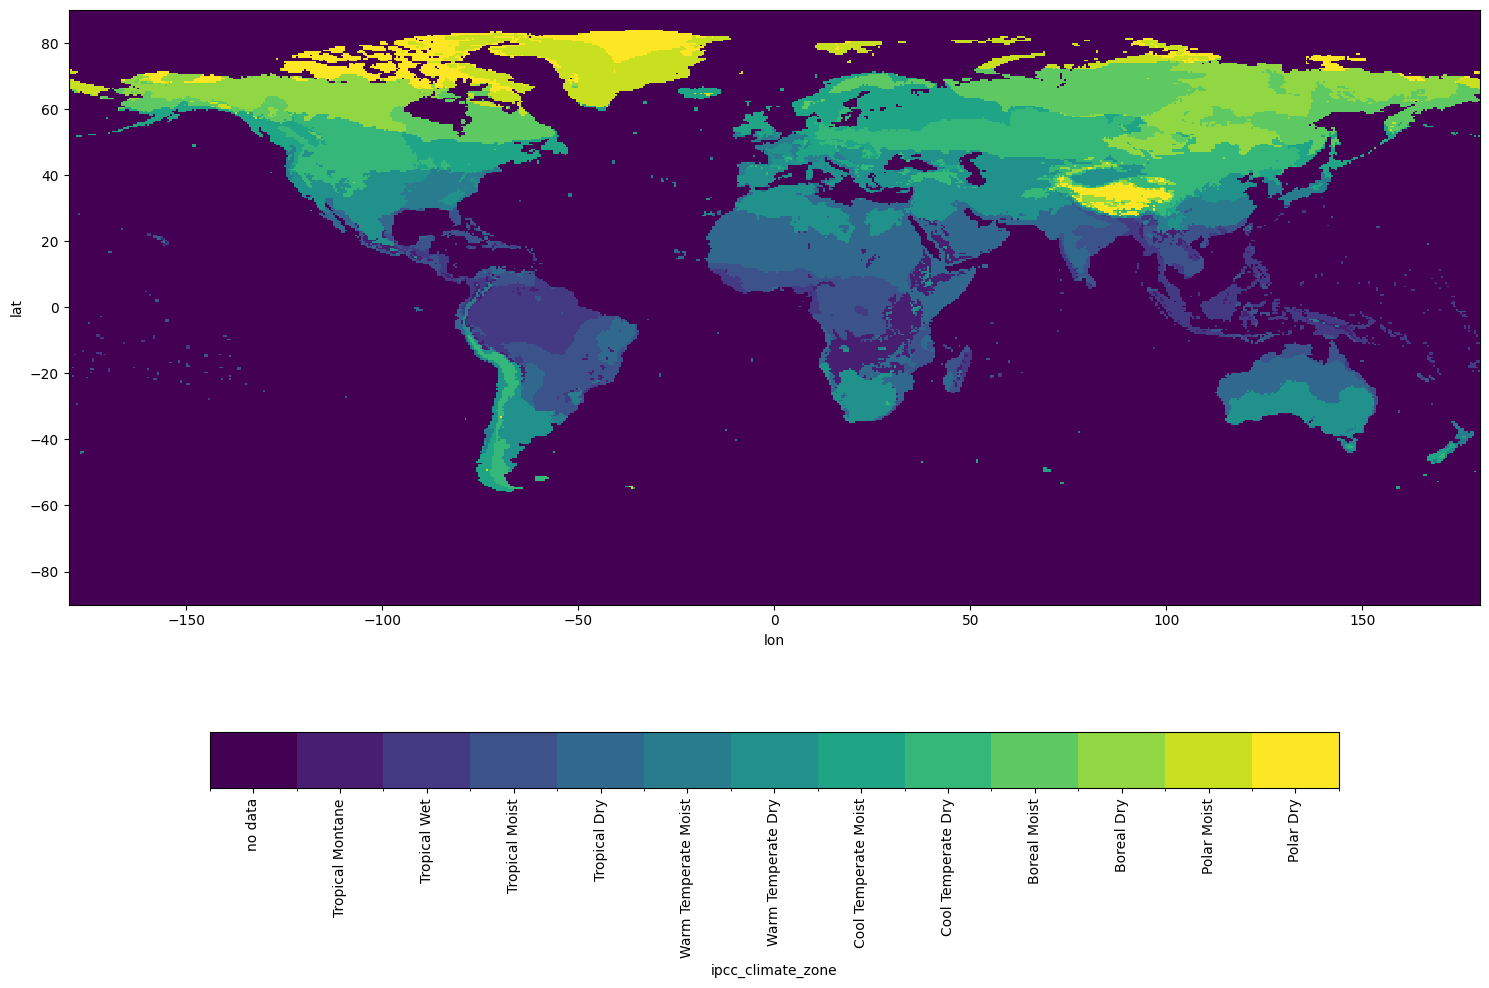

In [29]:
fig = climate_zones.plot(
    cmap=cmap,
    levels=levels,
    cbar_kwargs={
        'ticks': ticks,
        'location': 'bottom', 'shrink': 0.8},
    figsize=(15, 10),
);
fig.colorbar.set_ticklabels(labels, rotation=90);
plt.tight_layout();
plt.savefig("../data/ipcc_climate_zones.png", dpi=100)